In [15]:
#Reading data

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import csv as csv
import sklearn
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11456 entries, 0 to 11455
Data columns (total 8 columns):
ID                11456 non-null int64
Name              8231 non-null object
DateTime          11456 non-null object
AnimalType        11456 non-null object
SexuponOutcome    11456 non-null object
AgeuponOutcome    11450 non-null object
Breed             11456 non-null object
Color             11456 non-null object
dtypes: int64(1), object(7)
memory usage: 716.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
AnimalID          26729 non-null object
Name              19038 non-null object
DateTime          26729 non-null object
OutcomeType       26729 non-null object
OutcomeSubtype    13117 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26711 non-null object
Breed             26729 non-null object
Color             26729 non-null object
dtypes: 

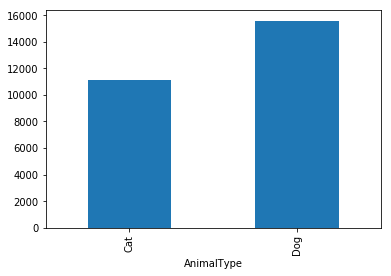

In [16]:
# load the data

train_df = pd.read_csv("shelter-animal-outcomes/train.csv.gz")
test_df = pd.read_csv("shelter-animal-outcomes/test.csv.gz")

print(test_df.info())
print(train_df.info())

#EDA
bal_population = train_df.groupby('AnimalType')['DateTime'].count()
bal_population.plot.bar()



In [17]:
#Replacing Nan with Unknown
train_df['OutcomeSubtype'].replace(np.nan, 'Unknown', regex=True, inplace=True)

In [18]:
# convert all of the AgeuponOutcome values into weeks

def convert_AgeuponOutcome_to_weeks(df):
    result = {}
    for k in df['AgeuponOutcome'].unique():
        if type(k) != type(""):
            result[k] = -1
        else:
            v1, v2 = k.split()
            if v2 in ["year", "years"]:
                result[k] = int(v1) * 52
            elif v2 in ["month", "months"]:
                result[k] = int(v1) * 4.5
            elif v2 in ["week", "weeks"]:
                result[k] = int(v1)
            elif v2 in ["day", "days"]:
                result[k] = int(v1) / 7
                
    df['_AgeuponOutcome'] = df['AgeuponOutcome'].map(result).astype(float)
    df = df.drop('AgeuponOutcome', axis = 1)
                
    return df

train_df = convert_AgeuponOutcome_to_weeks(train_df)
test_df = convert_AgeuponOutcome_to_weeks(test_df)
print("AgeuponOutcome conversion done.")


AgeuponOutcome conversion done.


In [19]:
# convert all of the remaining features to numeric values

def convert_to_numeric(df):
    for col in ['Name', 'AnimalType', 'SexuponOutcome',
                'Breed', 'Color', 'OutcomeType']:
        if col in df.columns:
            _col = "_%s" % (col)
            values = df[col].unique()
            _values = dict(zip(values, range(len(values))))
            df[_col] = df[col].map(_values).astype(int)
            df = df.drop(col, axis = 1)
    return df

train_df = convert_to_numeric(train_df)
test_df = convert_to_numeric(test_df)

print("Numerical conversion of features done.")

Numerical conversion of features done.


In [20]:
# fix the DateTime column

def fix_date_time(df):
    def extract_field(_df, start, stop):
        return _df['DateTime'].map(lambda dt: int(dt[start:stop]))
    df['Year'] = extract_field(df,0,4)
    df['Month'] = extract_field(df,5,7)
    df['Day'] = extract_field(df,8,10)
    df['Hour'] = extract_field(df,11,13)
    df['Minute'] = extract_field(df,14,16)
    
    return df.drop(['DateTime'], axis = 1)

train_df = fix_date_time(train_df)
test_df = fix_date_time(test_df)

print("DateTime column split into parts done.")

DateTime column split into parts done.


In [21]:
# re-index train_df so that ID is first and Target (_OutcomeType) is last

train_df = train_df.reindex(columns = ['AnimalID', '_Name',
                                       '_AnimalType', '_SexuponOutcome',
                                       '_AgeuponOutcome', '_Breed', '_Color',
                                       'Year', 'Month', 'Day', 'Hour', 'Minute',
                                       '_OutcomeType'])
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 13 columns):
AnimalID           26729 non-null object
_Name              26729 non-null int32
_AnimalType        26729 non-null int32
_SexuponOutcome    26729 non-null int32
_AgeuponOutcome    26729 non-null float64
_Breed             26729 non-null int32
_Color             26729 non-null int32
Year               26729 non-null int64
Month              26729 non-null int64
Day                26729 non-null int64
Hour               26729 non-null int64
Minute             26729 non-null int64
_OutcomeType       26729 non-null int32
dtypes: float64(1), int32(6), int64(5), object(1)
memory usage: 2.0+ MB
None


In [22]:
# split the data into a training set (80%) and a validation set (20%)

cut = int(len(train_df) * 0.8)
_validation_df = train_df[cut:]
_train_df = train_df[:cut]

print(len(_train_df))
print(len(_validation_df))

21383
5346


In [23]:
type(train_df)
train_df.isnull().sum()

AnimalID           0
_Name              0
_AnimalType        0
_SexuponOutcome    0
_AgeuponOutcome    0
_Breed             0
_Color             0
Year               0
Month              0
Day                0
Hour               0
Minute             0
_OutcomeType       0
dtype: int64

In [24]:
# build a classifier with scikit-learn - AdaBoost


from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

A1 = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 2),
                        n_estimators = 100,
                        learning_rate = 0.1)

classifiers = [c.fit(_train_df.values[:,1:-1],
                     _train_df.values[:,-1].astype(int)) \
               for c in [A1]]
results = [c.predict_proba(_validation_df.values[:,1:-1]) \
           for c in classifiers]
print(results[0])


[[0.23264917 0.1749446  0.25557164 0.21633075 0.12050385]
 [0.24142535 0.18916949 0.24386223 0.2317262  0.09381674]
 [0.24314206 0.21635891 0.19698164 0.22406924 0.11944815]
 ...
 [0.23494896 0.18280779 0.23424835 0.22406024 0.12393467]
 [0.16505102 0.23280716 0.09194534 0.29860985 0.21158662]
 [0.14321332 0.19964865 0.14150317 0.29156018 0.22407469]]


In [25]:
# calculate the log loss of result

from sklearn.metrics import log_loss

print([log_loss(_validation_df.values[:,-1].astype(int), r) for r in results])



[1.3743101163358022]


In [26]:
#Test data

ab = classifiers[0].fit(train_df.values[:,1:-1],
                        train_df.values[:,-1].astype(int))




In [27]:
# and use the classifier on test_df

ab_result = ab.predict_proba(test_df.values[:,1:])
ab_sub_df = pd.DataFrame(ab_result, columns=['Adoption', 'Died', 'Euthanasia',
                                             'Return_to_owner', 'Transfer'])
ab_sub_df.insert(0, 'ID', test_df.values[:,0].astype(int))

print(ab_sub_df)

# write to submission files

ab_sub_df.to_csv("submission.csv", index = False)



          ID  Adoption      Died  Euthanasia  Return_to_owner  Transfer
0          1  0.263052  0.151205    0.131080         0.328896  0.125767
1          2  0.256032  0.150986    0.145797         0.327620  0.119565
2          3  0.265083  0.142077    0.129677         0.339719  0.123444
3          4  0.253857  0.149044    0.143764         0.325552  0.127783
4          5  0.257525  0.149688    0.145761         0.325928  0.121098
5          6  0.242688  0.147425    0.133562         0.334882  0.141443
6          7  0.227382  0.154990    0.172216         0.300850  0.144562
7          8  0.204594  0.160070    0.174448         0.297276  0.163612
8          9  0.252378  0.150510    0.140552         0.322682  0.133878
9         10  0.277430  0.146258    0.138057         0.327562  0.110692
10        11  0.270207  0.147227    0.130880         0.321541  0.130145
11        12  0.245334  0.151820    0.134771         0.338580  0.129496
12        13  0.260068  0.146237    0.123236         0.333299  0

In [ ]:
#Future scope: RandomForest